# Recognizing handwritten Persian digits with a CNN
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saman-emami/hoda-cnn/blob/main/notebooks/train_hoda_cnn.ipynb)

This notebook demonstrates how to build and train a Convolutional Neural Network (CNN) using TensorFlow and Keras to recognize handwritten Persian digits from the Hoda dataset.

## Importing required libraries

In [70]:
import struct
import sys
from datetime import datetime
from pathlib import Path
from random import randint

import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Load the Hoda dataset

In [71]:
IN_COLAB = 'google.colab' in sys.modules

try:
  if IN_COLAB:
    # If you opened this notebook inside google colab
    DATASET_PATH = "./hoda_32x32_normalized.npz"
    if not Path(DATASET_PATH).exists():
      !wget -q https://github.com/saman-emami/hoda-cnn/raw/refs/heads/main/data/processed/hoda_32x32_normalized.npz

    data = np.load("./hoda_32x32_normalized.npz")
  else:
    # If you cloned the repo
    data = np.load("../data/processed/hoda_32x32_normalized.npz")
except Exception as e:
  print(f"Could not load Hoda dataset.\nError: {e}")

print(f"images shape: {np.shape(data['images'])} \nlabels shape: {np.shape(data['labels'])}")

images shape: (102352, 32, 32, 1) 
labels shape: (102352,)


Slicing the dataset to two parts for training and testing

In [72]:
INPUT_SIZE = (32, 32)
TRAINING_SET_LENGTH = 15000

try:

  train_images, train_labels = data["images"][:-TRAINING_SET_LENGTH], data["labels"][:-TRAINING_SET_LENGTH]
  test_images, test_labels = data["images"][-TRAINING_SET_LENGTH:], data["labels"][-TRAINING_SET_LENGTH:]

except Exception as e:
  print(f"Could not load Hoda dataset.\nError: {e}")

## Visualizing samples

The training images:

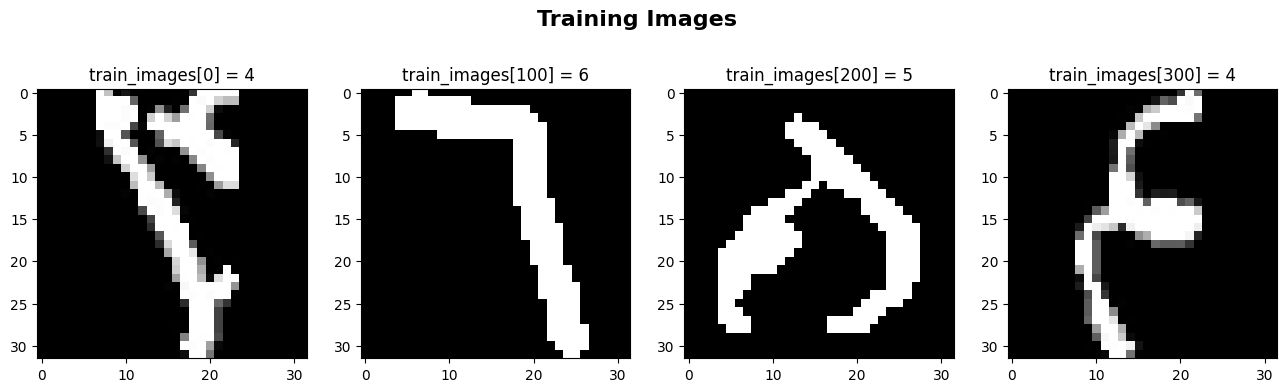

In [73]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Plot training images
for i in range(4):
    idx = i * 100
    axes[i].imshow(train_images[idx].reshape(INPUT_SIZE), cmap='gray')
    axes[i].set_title(f"train_images[{idx}] = {train_labels[idx]}")

fig.suptitle("Training Images", fontsize=16, fontweight='bold', y=1.03)

plt.show()


The test images:

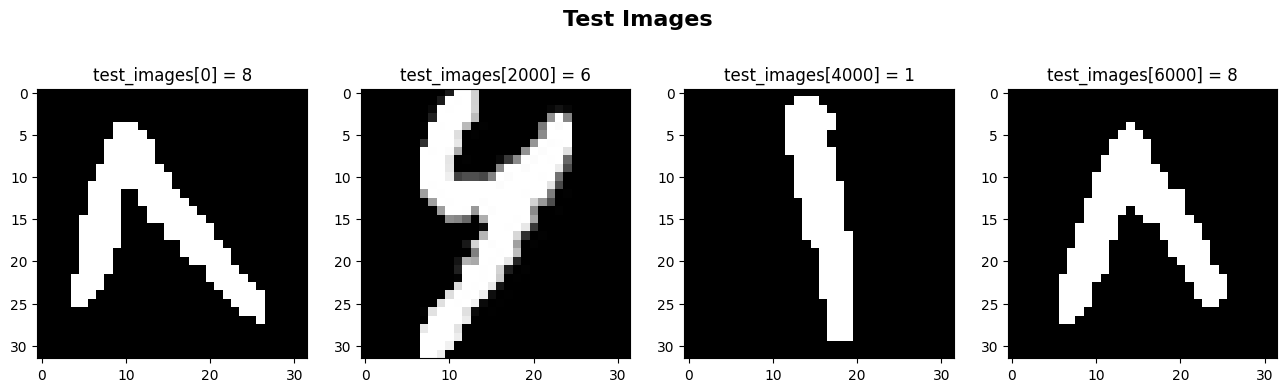

In [74]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4))

# Plot test images
for j in range(4):
    idx = j * 2000
    axes[j].imshow(test_images[idx].reshape(INPUT_SIZE), cmap='gray')
    axes[j].set_title(f"test_images[{idx}] = {test_labels[idx]}")

fig.suptitle("Test Images", fontsize=16, fontweight='bold', y=1.03)

plt.show()


## Build the Convolutional Neural Network model

We will use the Keras Sequential API


In [75]:
model = models.Sequential()

### Layer 0: Input layer

This specifies the shape of the input data.

In [76]:
# This is the recommended way and avoids UserWarnings.
INPUT_SHAPE = (*INPUT_SIZE, 1)

model.add(layers.Input(shape=INPUT_SHAPE))

### Layer 1: Convolution + ReLU

In [77]:
L1_FILTERS_COUNT = 32
L1_KERNEL_SIZE = (5, 5)

model.add(layers.Conv2D(L1_FILTERS_COUNT, L1_KERNEL_SIZE, activation='relu'))

### Layer 2: Max Pooling

In [78]:
L2_WINDOW_SIZE = (2, 2)

model.add(layers.MaxPooling2D(L2_WINDOW_SIZE))

In [79]:
model.add(layers.Dropout(0.07))

### Layer 3: Another Convolution + ReLU

In [80]:
L3_FILTERS_COUNT = 32
L3_KERNEL_SIZE = (3, 3)

model.add(layers.Conv2D(L3_FILTERS_COUNT, L3_KERNEL_SIZE, activation='relu'))

### Layer 4: Another Max Pooling

In [81]:
L4_WINDOW_SIZE = (2, 2)

model.add(layers.MaxPooling2D(L4_WINDOW_SIZE))

In [82]:
model.add(layers.Dropout(0.07))

### Layer 5: A Final Convolution + ReLU



In [83]:
L5_FILTERS_COUNT = 32
L5_KERNEL_SIZE = (3, 3)

model.add(layers.Conv2D(L5_FILTERS_COUNT, L5_KERNEL_SIZE, activation='relu'))

### Layer 6: Flatten

 Converts the 3D feature maps into a 1D vector for the dense layers.

In [84]:
model.add(layers.Flatten())

### Layer 7: Dense (Fully-Connected) Layer

In [85]:
model.add(layers.Dense(16, activation='relu'))

In [86]:
model.add(layers.Dropout(0.07))

### Layer 8: Output Layer

Dense layer with 10 neurons (one for each digit) and softmax activation to produce a probability distributation over the classes.

In [87]:
model.add(layers.Dense(10, activation='softmax'))

## Compile the model

We can print a summary of the model to see the architecture and number of parameters.


In [88]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 6, 6, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │         8,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,706 (108.23 KB)

 Trainable params: 27,706 (108.23 KB)

 Non-trainable params: 0 (0.00 B)

## Train the model

In [89]:
validation_data = (test_images, test_labels)

history = model.fit(train_images, train_labels, epochs=10, validation_data=validation_data)

Epoch 1/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - accuracy: 0.8624 - loss: 0.4162 - val_accuracy: 0.9868 - val_loss: 0.0448
Epoch 2/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 137s 32ms/step - accuracy: 0.9796 - loss: 0.0659 - val_accuracy: 0.9920 - val_loss: 0.0243
Epoch 3/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 141s 31ms/step - accuracy: 0.9878 - loss: 0.0402 - val_accuracy: 0.9933 - val_loss: 0.0254
Epoch 4/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 86s 32ms/step - accuracy: 0.9906 - loss: 0.0306 - val_accuracy: 0.9952 - val_loss: 0.0179
Epoch 5/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 142s 32ms/step - accuracy: 0.9916 - loss: 0.0259 - val_accuracy: 0.9947 - val_loss: 0.0152
Epoch 6/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 86s 31ms/step - accuracy: 0.9939 - loss: 0.0202 - val_accuracy: 0.9955 - val_loss: 0.0171
Epoch 7/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 143s 32ms/step - accuracy: 0.9939 - loss: 0.0201 - val_accuracy: 0.9953 - val_loss: 0.0136
Epoch 8/10
2730/2730 ━━━━━━━━━━━━━━━━━━━━ 140s 31ms/step - accuracy: 0.9

## Evaluate the model

After training the model, we evaluate the model's final performance on unseen data.

In [95]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

469/469 - 5s - 10ms/step - accuracy: 0.9966 - loss: 0.0143


## Visualize training results

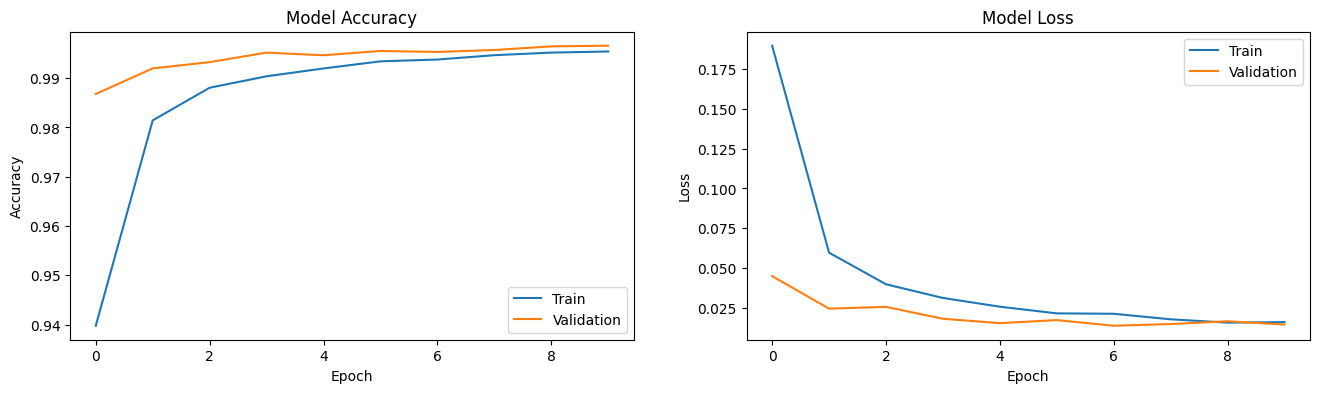

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend();


## Sample predictions

469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step


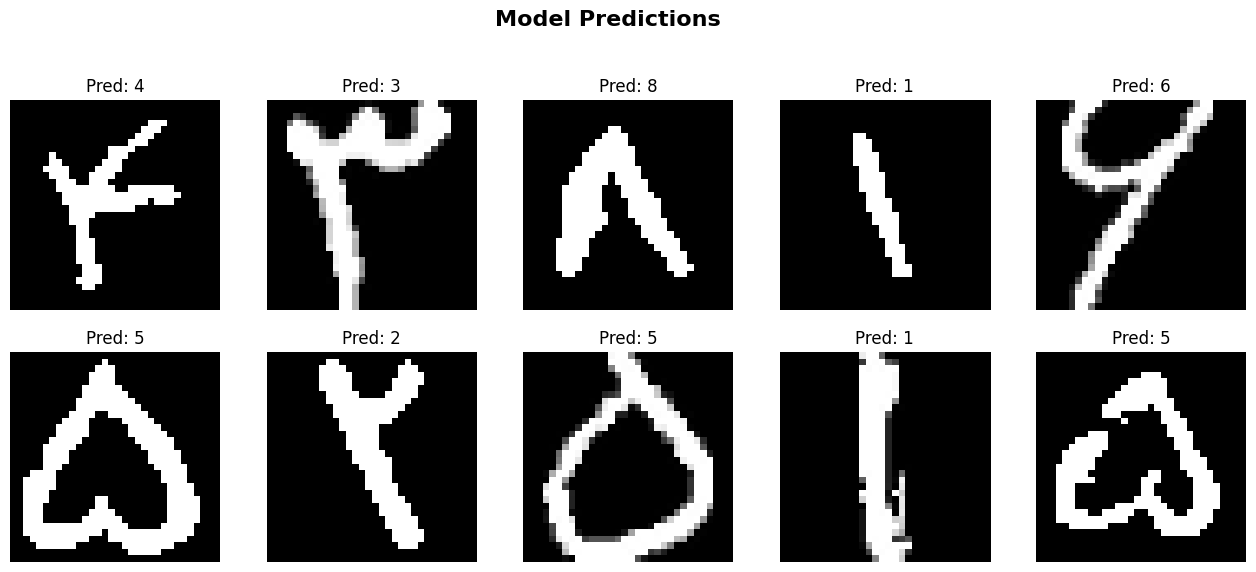

In [101]:
# Predict on test set
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Display 10 sample predictions
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(16, 6))
for i in range(10):
  idx = randint(0, len(test_images))
  row = i // 5
  col = i % 5
  axes[row, col].imshow(test_images[idx].squeeze(), cmap='gray')
  axes[row, col].set_title(f"Pred: {predicted_labels[idx]}")
  axes[row, col].axis('off')
fig.suptitle("Model Predictions", fontsize=16, fontweight='bold', y=1.03);

## Confusion matrix

<Figure size 800x800 with 0 Axes>

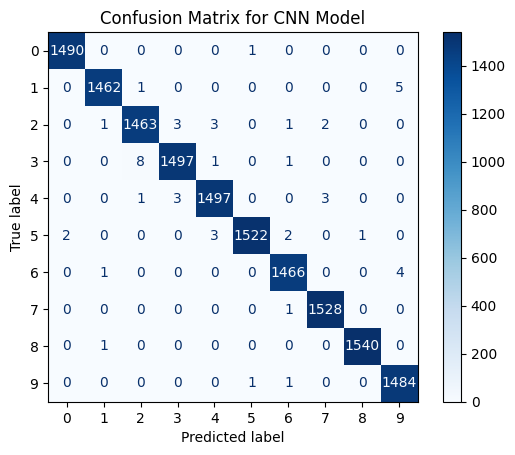

In [98]:
# Compute the confusion matrix
matrix = confusion_matrix(test_labels, predicted_labels)

# Display the confusion matrix
display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=range(10))
plt.figure(figsize=(8, 8))
display.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix for CNN Model")
plt.show()

## Saving the model

In [100]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"hoda_cnn_{timestamp}.keras"
save_model_path = filename if IN_COLAB else f"../models/{filename}"

model.save(save_model_path)